In [1]:
import numpy as np
import json
import cv2 as cv
import matplotlib.pyplot as plt
import string
import pandas as pd
import pytesseract as pt
import os
from parallel_searcher import *
import concurrent.futures
from symspellpy import SymSpell, Verbosity
from difflib import SequenceMatcher
from PIL import Image

### Загрузка приложенного датасета

In [2]:
pathes = []
for path, _, files in os.walk('./data'):
    if len(files) == 0:
        continue

    t_pathes = [f'{path}\\' + file for file in files]
    pathes.append(t_pathes)

raw_pathes = []

for folder in pathes:
    for path in folder:
        raw_pathes.append(path)

In [3]:
pt.pytesseract.tesseract_cmd = "D:/Tools/Tesseract-OCR/tesseract.exe"

### Препроцессинг входного изображения

In [112]:
img = np.array(Image.open(raw_pathes[170])) # исходное изображение

if img.size // 300 // 3 < 1700:
   shape = (int(img.shape[0] * 1.3), int(img.shape[1] * 1.3))
   img = cv.resize(img, shape, fx=0, fy=0, interpolation=cv.INTER_CUBIC)

In [110]:
def image_preprocessing(src):
   gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
   blured1 = Image.fromarray(cv.medianBlur(gray, 3))
   blured2 = Image.fromarray(cv.medianBlur(gray, 51))
   divided = np.ma.divide(blured1, blured2).data
   normed = np.uint8(255 * divided / divided.max())
   th, threshold = cv.threshold(normed, 100, 255, cv.THRESH_OTSU)

   return threshold

1. Распознавание исходного текста на картинке с использованием библиотеки PyTesseract
2. Фильтрация выходных синтаксических токенов: выборка наиболее вероятных слов

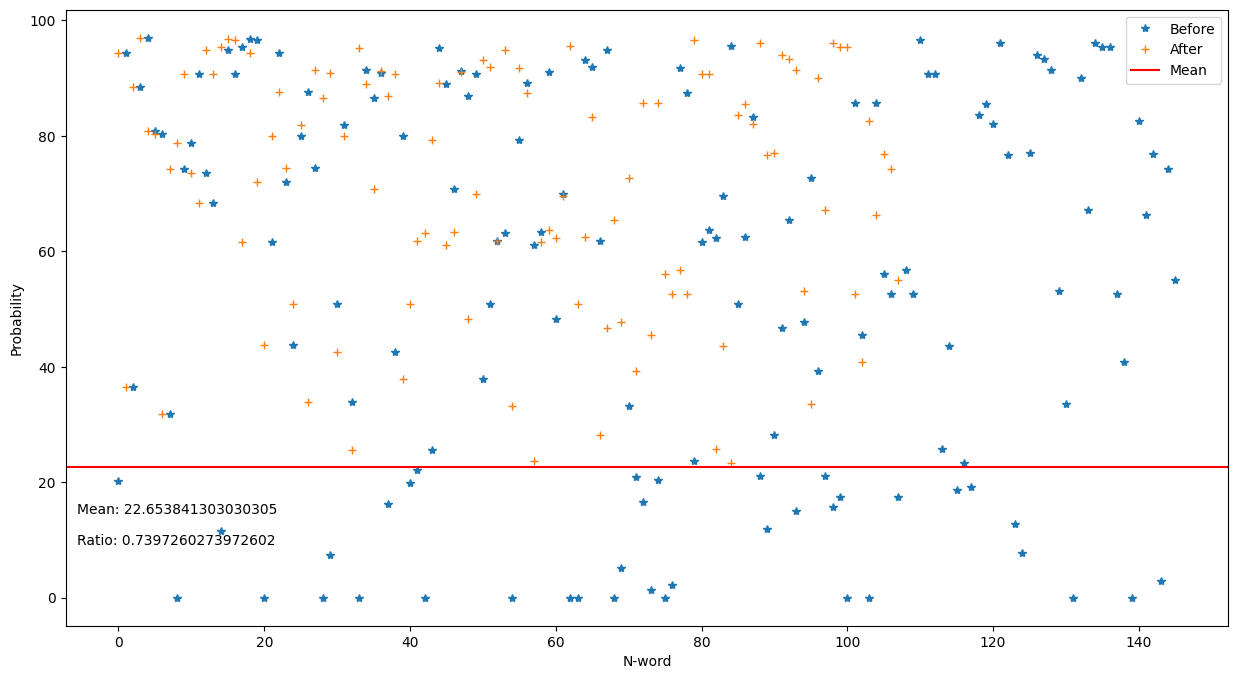

In [113]:
prepared_img = image_preprocessing(img)
data : pd.DataFrame = pt.image_to_data(prepared_img, lang='rus+eng', output_type=pt.Output.DATAFRAME, config=f'--psm 12')
data = data.dropna(subset=['text'])

len_before = data.shape[0]

mean = data['conf'].mean()
under_mean = data[data['conf'] <= mean]['conf'].mean()

fig, axs = plt.subplots(1,1,  figsize=(15, 8))
plt.plot(range(data.shape[0]), data['conf'], '*')

data = data[data['conf'] >= under_mean]
plt.plot(range(data.shape[0]), data['conf'], '+')
plt.axline((0, under_mean), (1, under_mean), color='red')

plt.legend(['Before', 'After', 'Mean'])
plt.xlabel('N-word')
plt.ylabel('Probability')

plt.text(.01, 0.15, f'Ratio: {data.shape[0] / len_before}', ha='left', va='top', transform=axs.transAxes)
plt.text(.01, 0.20, f'Mean: {under_mean}', ha='left', va='top', transform=axs.transAxes)
plt.show()

In [7]:
data

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,12,11,61,37,63.536713,(©
7,5,1,1,1,1,4,257,9,140,39,90.043457,МОЛОЧНАЯ
8,5,1,1,1,1,5,406,9,284,48,88.929489,БЫСТРОРАСТВОРИМАЯ
9,5,1,1,1,1,6,697,9,183,44,88.119751,ОБОГАЩЕННАЯ
13,5,1,2,1,1,1,13,58,275,39,79.848274,ПРОБИОТИЧЕСКИМИ
...,...,...,...,...,...,...,...,...,...,...,...,...
250,5,1,20,1,1,6,349,842,49,21,71.278236,MeCTE
251,5,1,20,1,1,7,405,842,19,21,95.560593,не
252,5,1,20,1,1,8,427,831,54,43,85.518234,более
253,5,1,20,1,1,9,488,843,41,28,85.596725,двух


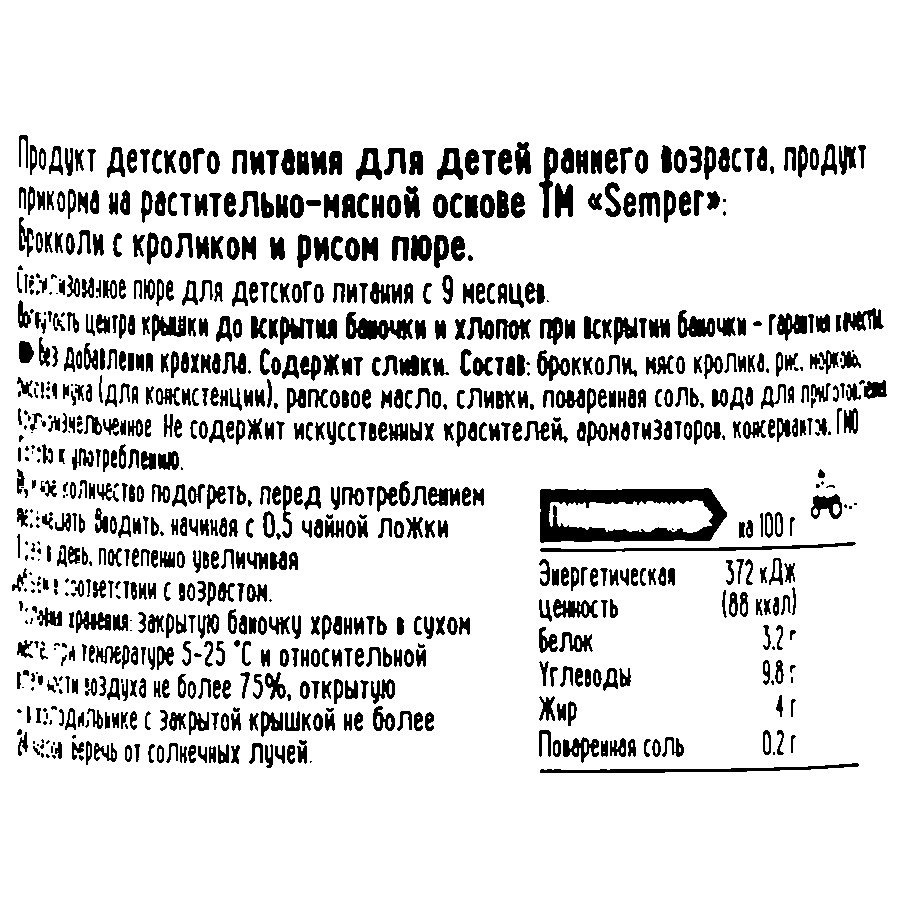

In [114]:
Image.fromarray(prepared_img)

In [115]:
' '.join(data['text'])

'Детского питания ДЛя Детей раннего возраста, продук ка растительно-мясной осмове TM «Зетрег»: с кроликом и рисом пюре. nope для детского питания с 9 месяцев крышки До кирытия и хлопок при баночки ~ крохнала. Содержит сливки. Состав: брокколи, нясо кролика, ри. MIEN киа (ДЛЯ рапсовое масло, сливки, поваремная соль, юде ДЛЯ He содержит искусственчых красителей, № подогреть, ne Жить Модить, начиная с 0, ед употреблением чайной Ложки =. a 1 пктепено увеличивая Энергетическая с возрастом. 88 ккал, Чи Закрытую баночку хранить в сухом TOK jer ‘та 5-25 °С и относительной 38: ке более 75%, открытую Yrnesoay dr с закрытой крышкой не более Kup <a от солнечных Лучей. СОЛЬ 021'

### Инициализация орфографических корректировщиков

In [ ]:
!wget http://dict.ruslang.ru/Freq2011.zip 
!tar -xf ./Freq2011.zip

os.remove('./Freq2011.zip')
os.remove('./freqrnc_readme.txt')
os.replace('./freqrnc2011.csv', './dict/freqrnc2011.csv')

Большой словарь русских слов во всех морфологических формах (1 531 464 записи) 

In [ ]:
!wget https://github.com/danakt/russian-words/raw/master/russian.txt
text = open('./russian.txt', encoding='windows-1251').read()
with open('./dict/russian.txt', 'w', encoding='utf-8') as w:
    w.write(text)

os.remove('./russian.txt')

In [116]:
dict_filename = './dict/russian.txt'
big_dict = pd.read_csv(dict_filename)

Частотный словарь русского языка

In [117]:
freq_filename = './dict/dict_ru.csv'
freq_dict = pd.read_csv('./dict/freqrnc2011.csv', sep='\t')
freq_dict['Freq(ipm)']=freq_dict['Freq(ipm)'].apply(func=math.ceil)
freq_dict.to_csv(freq_filename, sep=' ', index=False, header=False)

In [118]:
spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
spell.load_dictionary(freq_filename, term_index=0, count_index=2, encoding='utf-8')

True

Инициализация процессов для паралелльной обработки словаря

In [119]:
#workers_cnt = 20
#target, positions = init_data(dict_filename, 0.75, workers_cnt)
#proc_bag = init_processbag(target, workers_cnt)

In [120]:
#for proc in proc_bag:
#    proc.terminate()

Это, мать вашу, лексический анализатор на минималках
```
Поддерживаемый алфавит:
1. [a-Z] + [а-Я]
2. [0-9]
3. [,]
```

In [121]:
class Kind:
    WS = 0
    Numerical = 1
    Word = 2
    EOF = 3
    Punc = 4
    Bad = 5

class Token():
    def __init__(self, text : str, kind : Kind, start_pos : int):
        self.text = text
        self.kind = kind
        self.start_pos = start_pos
    
    def __str__(self):
        return f'{self.text} {self.kind} {self.start_pos}'

class Lexer:
    def __init__(self, sentence : str) -> None:
        self.sentence = sentence
        self.__start_pos = 0
        self.__position = 0
        self.__end_pos = len(sentence)
        self.alphabet = set([i for i in (string.ascii_letters + 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя')])
        self.__kind : Kind = None

    def __lookahead(self, cnt) -> str:
        return self.sentence[self.__position + cnt] if self.__position + cnt < self.__end_pos else self.sentence[-1]

    def __getCurrChar(self) -> str:
        return self.sentence[self.__position] if self.__position < self.__end_pos else '\0'

    def __lex(self):
        self.__start_pos = self.__position

        match self.__getCurrChar():
            case '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9' :
                self.__lexNumericalToken()
            case ' ' | '\n' | '\r' | '\t':
                self.__lexWhiteSpaceToken()
            case ',':
                self.__kind = Kind.Punc
                self.__position += 1
            case '\0':
                self.__kind = Kind.EOF
            case _:
                if self.__getCurrChar() in self.alphabet:
                    self.__lexWordToken()
                else:
                    self.__kind = Kind.Bad
                    self.__position += 1
                
        span = self.sentence[self.__start_pos : self.__position]
        return Token(span, self.__kind, self.__start_pos)

    def __lexWordToken(self):
        while self.__getCurrChar() in self.alphabet:
            self.__position += 1

        self.__kind = Kind.Word

    def __lexWhiteSpaceToken(self):
        while self.__getCurrChar() in string.whitespace:
            self.__position += 1

        self.__kind = Kind.WS

    def __lexNumericalToken(self):
        while True:
            ch = self.__getCurrChar()
            if ch in string.digits:
                self.__position += 1
            elif ch == ',':
                if self.__lookahead(1) in string.digits:
                    self.__position += 1
                else:
                    break
            else:
                break
        
        self.__kind = Kind.Numerical

        
    def tokenize(self) -> list[Token]:
        tokens = []
        token = self.__lex()
        while token.kind != Kind.EOF:
            tokens.append(token)
            token = self.__lex()
        tokens.append(token)
        return tokens


Стоит также отметить, что служебные части речи и местоимения не несут никакой смысловой нагрузки. Поэтому, чтобы, теоретически, увеличить точность алгоритма, необходимо также отсеивать их.

In [122]:
def evaluate_weight(src_word, target_word):
    weight = 0
    min_len = min(len(src_word), len(target_word))
    for i in range(min_len):
        weight += min_len - i if src_word[i] == target_word[i] else 0
    
    weight -= abs(len(target_word) - len(src_word))

    return weight

def quick_search(word):
    suggestions = [sg.term for sg in spell.lookup(word, max_edit_distance=2, verbosity=Verbosity.CLOSEST)]
    if len(suggestions) == 0:
        return []
    
    weights = [evaluate_weight(word, s_word) for s_word in suggestions]
    best_weight = max(weights)
    return [term for i, term in enumerate(suggestions) if weights[i] == best_weight]


def heavy_search(word): # Хз, зачем потел в этот хеви поиск, если результат +- тот же, а времени тратится в 240x больше
    suggestions = find_async(word, proc_bag, positions)
    if len(suggestions) == 0:
        return []

    weights = [evaluate_weight(word, s_word) for s_word in suggestions]
    best_weight = max(weights)
    return [term for i, term in enumerate(suggestions) if weights[i] == best_weight]


def lemmatization(word, keywords : list[str], enable_heavy):
    suggestions = quick_search(word)
    if len(suggestions) == 0 and enable_heavy:
        suggestions = heavy_search(word)
    if len(suggestions) == 0:
        suggestions = [word]
    
    for sg in suggestions:
        for kw in keywords:
            if kw in sg:
                return kw
        
    return suggestions[0]
    

def normilize(src : str, keywords : set[str] = set(), enable_heavy : bool = False) -> list[Token]: # Нормализация строки: удаление всякого ненужного говна
    whitelist = set(string.ascii_letters + string.digits + 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя., ')
    bad_pos = set('spro apro advpro pr conj part intj init'.split())

    clear_str = ''
    for ch in src:
        clear_str += ch if ch in whitelist else ''

    clear_str = clear_str.lower()
    normilized_tokens : list[Token] = []
    tokens = Lexer(clear_str).tokenize()

    for token in tokens:
        match token.kind:
            case Kind.Word:
                lemma = lemmatization(token.text, keywords, enable_heavy) # лемматизация
                PoS = freq_dict[freq_dict['Lemma'] == lemma]['PoS'] # часть речи слова
                
                if PoS.__len__() == 0:
                    normilized_tokens.append(Token(lemma, token.kind, token.start_pos))
                    continue
                
                part = PoS.to_string(index=False)
                if part not in bad_pos:
                    new_token = Token(lemma, token.kind, token.start_pos) # добавляем лемматизированный токен
                    normilized_tokens.append(new_token)

            case Kind.Numerical:
                normilized_tokens.append(token)

    return normilized_tokens

In [123]:
class NumberRecognition:
    def __init__(self, tokens : list[Token]) -> None:
        self.tokens = tokens

    def __nearest_num(self, curr_pos : int, window_size : int) -> float: # первое вхождение числа в строке
        span : list[Token] = self.tokens[curr_pos:] if curr_pos + window_size >= len(self.tokens) else self.tokens[curr_pos : curr_pos + window_size]
        for token in span:
            if token.kind == Kind.Numerical:
                return float(token.text.replace(',', '.'))
            
        return None


    def recognize(self, window_size : int = 2, keywords : set[str] = set()): # анализ строки на наличие некоторого множества ключевых слов, затем поиск ближайших чисел к этим словам
        values = {}
        for i, token in enumerate(self.tokens):
            for kw in keywords:
                if kw in token.text:
                    values[kw] = self.__nearest_num(i, window_size)
                    break

        for kw in keywords: # присваивание дефолтных значений нераспознанным ключ. словам
            if kw not in values.keys():
                values[kw] = None

        return values

### Загрузка лимитов

In [124]:
class Limit:
    def __init__(self, bad_contains : list, bad_condition : list) -> None:
        self.bad_contains = bad_contains
        self.bad_condition = bad_condition


limits_path = './limits/'

files = []
for _, _, f in os.walk(limits_path):
    files = f

limits = {}
for file in files: # Загрузка лимитов из файлов
    path = limits_path + file
    limit = Limit(**json.loads(open(path, encoding='utf-8').read()))
    limits[file[:-5]] = limit

### Категории

In [125]:
class Feauture:
    def __init__(self, min_val, max_val) -> None:
        self.min_val = min_val if min_val != -1 else 0
        self.max_val = max_val if max_val != -1 else math.inf
        
class ConditionItem:
    def __init__(self, ans : bool, id = -1) -> None:
        mapper = {
            1 : 'energy', 
            2 : 'natrium',
            3 : 'sugar',
            4 : 'protein',
            5 : 'fat', 
            6 : 'fruits',
        }

        self.type = mapper[id]
        self.ans = ans

class Category:
    def __init__(self, type : str,
                energy : Feauture, 
                natrium : Feauture,
                sugar : Feauture,
                protein : Feauture, 
                fat : Feauture, 
                fruits : Feauture) -> None:
        
        self.type = type
        self.energy = energy
        self.natrium = natrium
        self.sugar = sugar
        self.protein = protein
        self.fat = fat
        self.fruits = fruits
        self.categ_arr = [energy, natrium, sugar, protein, fat, fruits]

        self.limit_set = False
        self.limits : list[Limit] = []
    
    def add_limit(self, limit : Limit): # У каждой категории может быть несколько лимитов
        self.limit_set = True
        self.limits.append(limit)
        return self
    
    def check_condition(self, energy, natrium, sugar, protein, fat, fruits): # Алгоритм проверки удовлетворения условиям, заданным в таблице
        arr = [energy, natrium, sugar, protein, fat, fruits]
        answer : list[ConditionItem] = []

        for i, item in enumerate(arr):
            if item is None:
                continue

            minv = self.categ_arr[i].min_val
            maxv = self.categ_arr[i].max_val

            item = ConditionItem(minv <= item <= maxv, i + 1)
            answer.append(item)

        return all([item.ans for item in answer]), answer
    
    
    def check_limits(self, src_tokens : list[Token]): # Алгоритм проверки лимитов
        if not self.limit_set:
            raise Exception('Limit entity is null')
    
        num_rcg = NumberRecognition(src_tokens)
        diagnostic = []
        answer = []
        for limit in self.limits:
            condition_res = []
            contains_res = []

            for cond in limit.bad_condition: # Плохие условия
                name, val = cond[0], cond[1]
                found = num_rcg.recognize(keywords=set([name]))
                condition_res.append(found[name] != val)
                diagnostic.append(('Условие:' + name + f'!={val}', found[name] != val))

            for cont in limit.bad_contains: # Плохой состав
                temp = [cont in token.text for token in src_tokens]
                contains_res.append(all(temp))
                diagnostic.append(('Содержит:'+cont, all(temp)))

            answer.append([all(condition_res), all(contains_res)])

        return all([all(l) for l in answer]), diagnostic # condition, contains

In [126]:
raw_categs = pd.read_csv('./categories.csv').to_numpy()
categories : list[Category] = []
for c in raw_categs:
    type_categ = str(c[0])
    energy = Feauture(c[1], c[2])
    natrium = Feauture(c[3], c[4])
    sugar = Feauture(c[5], c[6])
    protein = Feauture(c[7], c[8])
    fat = Feauture(c[9], c[10])
    fruits = Feauture(c[11], c[12])
    categories.append(Category(type_categ, energy, natrium, sugar, protein, fat, fruits))

categories[0].add_limit(limits['porridge'])
categories[1].add_limit(limits['milk'])
categories[2].add_limit(limits['fruits']).add_limit(limits['vegeb'])

In [127]:
default_keywords = [
    'энергет',
    'натр',
    'сахар',
    'белок',
    'жир',
    'фрукт',
]

product_class = '1.0' # класс продукта (1, 2, 3.1, 4.1, ...).
category = None
for categ in categories:
        if categ.type == product_class:
            category = categ
            break

In [133]:
src = ' '.join(data['text'])
normilized_tokens = normilize(src, default_keywords, enable_heavy=False)

num_rcg = NumberRecognition(normilized_tokens)
vals = num_rcg.recognize(keywords=default_keywords, window_size=5)
cond_valid, cond_results = category.check_condition(vals['энергет'],
                                                         vals['натр'], 
                                                         vals['сахар'], 
                                                         vals['белок'], 
                                                         vals['жир'], 
                                                         vals['фрукт'])

limit_valid = True
if category.limit_set:
    limit_valid, diagnostic = category.check_limits(normilized_tokens)

In [134]:
print('Source data : ' + str(vals))
if len(cond_results) != 0:
    print('For found keywords have evaluated conditions(see condition values in categories.csv file):')
    print('-' * 90)

for cond_res in cond_results:
    print('Keyword ' + '\033[1m' + str(cond_res.type) + '\033[0m' + ' is ' + ('\033[91m' if not cond_res.ans else  '\033[92m') + str(cond_res.ans) + '\033[0m')

if len(cond_results) != 0:
    print('-' * 90)

if len(diagnostic) != 0:
    print('For given sentences have checked limits(see limits in limits directory):')
    print('-' * 90)
    
for limit_res in diagnostic:
    print('Limit ' + '\033[1m' + str(limit_res[0]) + '\033[0m' + ' is ' + ('\033[91m' if not limit_res[1] else  '\033[92m') + str(limit_res[1]) + '\033[0m')

if len(diagnostic) != 0:
    print('-' * 90)

Source data : {'энергет': 88.0, 'натр': None, 'сахар': None, 'белок': None, 'жир': None, 'фрукт': None}
For found keywords have evaluated conditions(see condition values in categories.csv file):
------------------------------------------------------------------------------------------
Keyword energy is True
------------------------------------------------------------------------------------------
For given sentences have checked limits(see limits in limits directory):
------------------------------------------------------------------------------------------
Limit Условие:фруктовое!=100 is True
Limit Условие:овощное!=100 is True
Limit Условие:заменители!=100 is True
------------------------------------------------------------------------------------------
